In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime

In [2]:
def read_data():
    file = "craigslistVehicles.csv"
    input_data = pd.read_csv(file, sep=",")
    return input_data

input_data = read_data()

# Create Time Dataframe from URL Timestamp

In [3]:
def getTimestamp(x):
    s = str(x)
    arr1 = x.split('/')
    arr2 = arr1[-1].split('.')
    ts = int(arr2[0])
    dt = datetime.datetime.fromtimestamp(ts)
    return dt.year * 1000000 + dt.month * 10000 + dt.day * 100 + dt.hour

timestamp = input_data["url"].apply(getTimestamp)
timeDf = pd.DataFrame({'time': np.sort(timestamp)}).groupby(['time']).size().reset_index(name='counts')

# Data Cleaning

In [4]:
timeDf.describe()

,time,counts
count,1.367200e+04,13672.000000
mean,2.182656e+09,49.576653
std,4.870916e+05,64.982928
min,2.181101e+09,1.000000
25%,2.182093e+09,5.000000
50%,2.183022e+09,29.000000
75%,2.183071e+09,70.000000
max,2.183120e+09,553.000000


In [5]:
# We clean the values which are contributing very small numbers like 6, 9, 14 near the max timestamp values.
# The data for last 2-3 months seem to be partial and cut off. Thus we remove them
timeDf = timeDf[timeDf['time'] < 2183113018]

# Utility Functions

In [6]:
def split(Y):
    i = int(0.9 * len(Y))
    return Y[0:i], Y[i:]

In [7]:
def percent_error(y_predicted, y_actual):
    error = []
    for x in range(0,len(y_predicted)):
        val = (abs(y_predicted[x] - y_actual[x]) * 100)/y_actual[x]
        error.append(val)
    
    return np.mean(error)

# Moving Average

In [8]:
train, test = split(timeDf)
moving_avg = test.copy()
predictions = []

tmpDf = train.copy()
for i in range(len(test)):
    predictions.append(tmpDf[-30:].mean().iloc[-1])
    tmpDf = tmpDf.append([{'time': test['time'].iloc[i], 'counts': test['counts'].iloc[i]}])
    
moving_avg['moving_avg_prediction'] = predictions

Precent Error 15.723439370896932


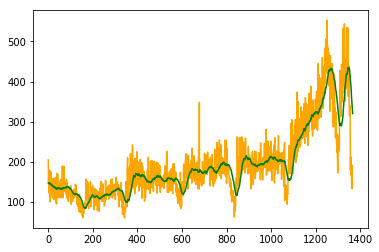

In [9]:
y_actual = test["counts"].values
movingAvgPercentError = percent_error(predictions, y_actual)
print("Precent Error", movingAvgPercentError)

plt.plot(y_actual, color='orange')
plt.plot(predictions, color='green')
plt.show()

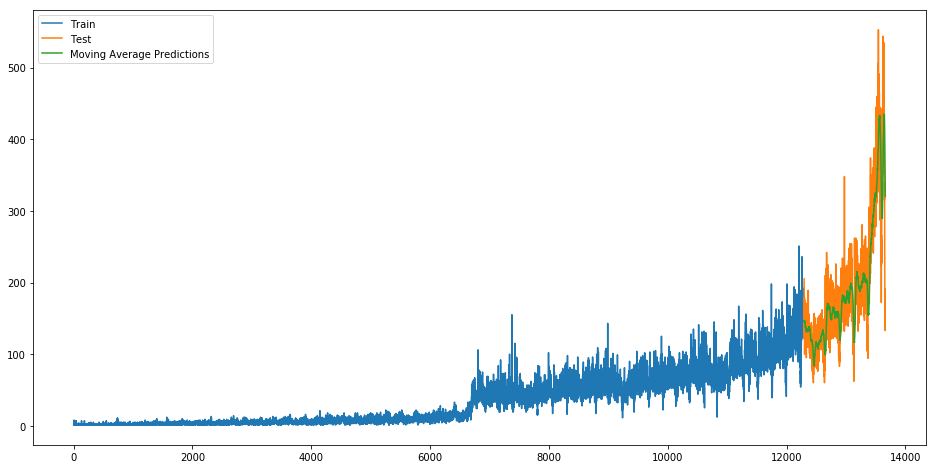

In [10]:
# Referred: https://www.analyticsvidhya.com/blog/2018/02/time-series-forecasting-methods/
plt.figure(figsize=(16,8))
plt.plot(train['counts'], label='Train')
plt.plot(test['counts'], label='Test')
plt.plot(moving_avg['moving_avg_prediction'], label='Moving Average Predictions')
plt.legend(loc='best')
plt.show()

# EWMA

In [11]:
def EWMA(sample_input, alpha, idx):
    
    base_case = 0.0
    for x in range(0, idx):
        base_case += sample_input[idx-x-1]*((1 - alpha)**x)
    
    base_case = alpha * base_case
    
    y_predicted = []
    y_predicted.append(base_case)
    for t in range(idx+1, len(sample_input)):
        y_predicted.append(alpha * sample_input[t-1] + (1 - alpha) * y_predicted[-1])
    
    y_actual = sample_input[idx:]
    error = percent_error(y_predicted, y_actual)
    
    return y_predicted, error

Precent Error 12.69272812785766


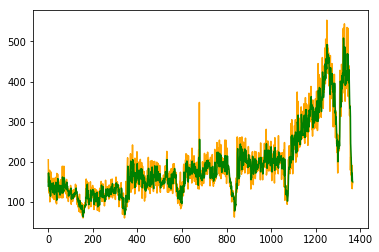

In [13]:
idx = int(0.9 * len(timeDf["counts"]))

full_data = timeDf["counts"].values
y_actual = full_data[idx:]
y_predicted, ewmaPercentError = EWMA(full_data, 0.5, idx)
print("Precent Error", ewmaPercentError)

plt.plot(y_actual, color='orange')
plt.plot(y_predicted, color='green')
plt.show()

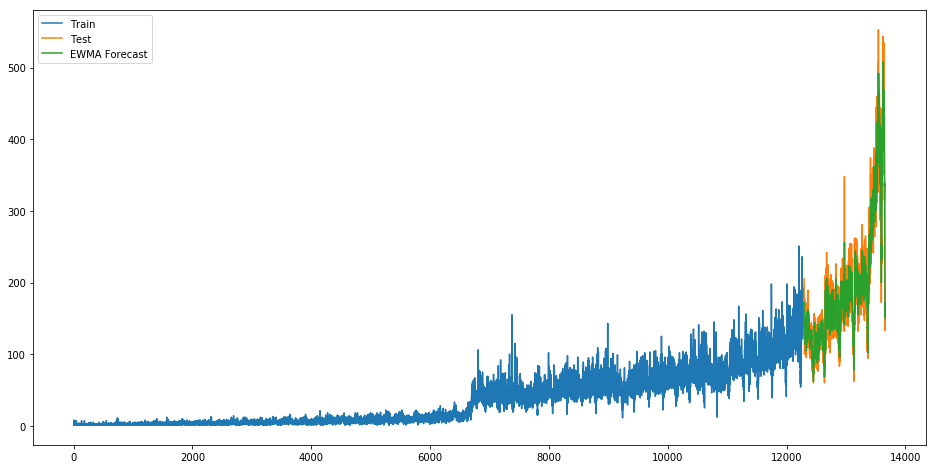

In [14]:
ewma_pred = test.copy()
ewma_pred['moving_avg_forecast'] = y_predicted
plt.figure(figsize=(16,8))
plt.plot(train['counts'], label='Train')
plt.plot(test['counts'], label='Test')
plt.plot(ewma_pred['moving_avg_forecast'], label='EWMA Forecast')
plt.legend(loc='best')
plt.show()

# Auto Regression

In [15]:
# Reference - https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/
from statsmodels.tsa.ar_model import AR

X = timeDf["counts"].values
idx = int(0.9 * len(X))
train, test = X[0:idx], X[idx:]

model = AR(train)
model_fit = model.fit()
bestLag = model_fit.k_ar
coef = model_fit.params

history = train[len(train)-bestLag:]
history = [history[i] for i in range(len(history))]
predictions = list()

for t in range(len(test)):
    length = len(history)
    lag = [history[i] for i in range(length-bestLag,length)]
    yhat = coef[0]
    
    for d in range(bestLag):
        yhat += coef[d+1] * lag[bestLag-d-1]

    obs = test[t]
    predictions.append(yhat)
    history.append(obs)

Percent Error 12.41148929546772


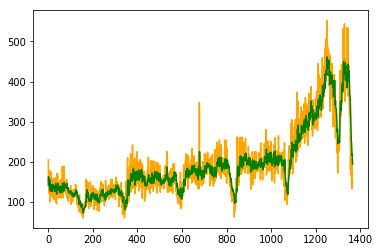

In [16]:
autoRegressionPercentError = percent_error(test, predictions)
print("Percent Error", autoRegressionPercentError)

plt.plot(test, color='orange')
plt.plot(predictions, color='green')
plt.show()

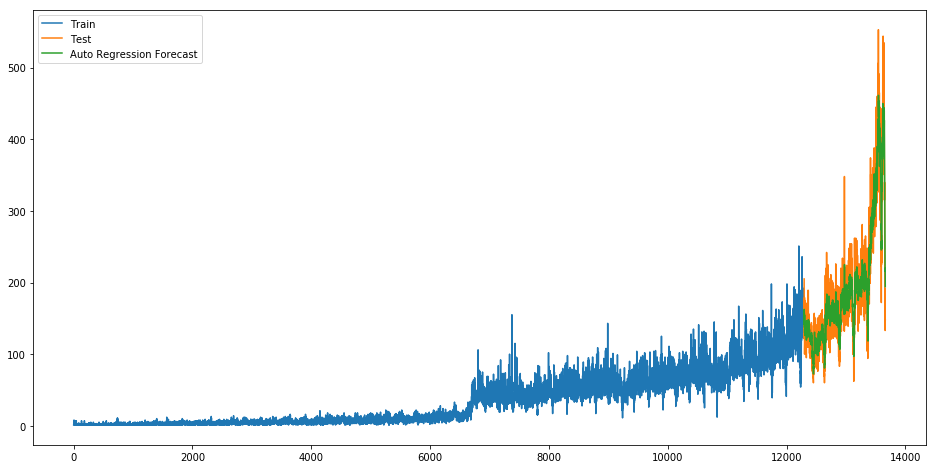

In [17]:
i = int(0.9 * len(timeDf))
train, test = timeDf[0:i], timeDf[i:]

lr_pred = test.copy()
lr_pred['moving_avg_forecast'] = predictions
plt.figure(figsize=(16,8))
plt.plot(train['counts'], label='Train')
plt.plot(test['counts'], label='Test')
plt.plot(lr_pred['moving_avg_forecast'], label='Auto Regression Forecast')
plt.legend(loc='best')
plt.show()

# Final Errors

In [18]:
time_series_models = ["Moving Average", "EWMA", "AR"]
percentage_errors = [movingAvgPercentError, ewmaPercentError, autoRegressionPercentError]
results = pd.DataFrame({
    'Time Series Models': time_series_models,
    'Percentage Errors': percentage_errors
})

results

,Time Series Models,Percentage Errors
0,Moving Average,15.723439
1,EWMA,12.692728
2,AR,12.411489
